In [1]:
#### Require python 3.10+
!python --version

Python 3.10.12


In [2]:
!pip uninstall nltk

Found existing installation: nltk 3.8.1
Uninstalling nltk-3.8.1:
  Would remove:
    /Users/navneev/miniforge3/envs/opensearch-examples/bin/nltk
    /Users/navneev/miniforge3/envs/opensearch-examples/lib/python3.10/site-packages/nltk-3.8.1.dist-info/*
    /Users/navneev/miniforge3/envs/opensearch-examples/lib/python3.10/site-packages/nltk/*
Proceed (Y/n)? ^C
ERROR: Operation cancelled by user


In [3]:
conda install -c conda-forge ipywidgets

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.14.0
  latest version: 23.7.4

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.

Retrieving notices: ...working... done

Note: you may need to restart the kernel to use updated packages.


In [26]:
!pip install --no-cache-dir opensearch-py python-dotenv boto3 tqdm h5py matplotlib ipywidgets jedi ipython sentence_transformers


In [4]:
# For autocomplete use shift+tab
%config IPCompleter.greedy=True

In [3]:
# Download a dataset Scifact

!curl -o scifact.zip -L https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/scifact.zip
!unzip scifact.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2750k  100 2750k    0     0   961k      0  0:00:02  0:00:02 --:--:--  968k
Archive:  scifact.zip
   creating: scifact/
   creating: scifact/qrels/
  inflating: scifact/qrels/train.tsv  
  inflating: scifact/qrels/test.tsv  
  inflating: scifact/corpus.jsonl    
  inflating: scifact/queries.jsonl   


In [59]:
# Read Data set

from tqdm.notebook import tqdm
import json

corpus_file = "./scifact/corpus.jsonl"
queries_file = "./scifact/queries.jsonl"

num_lines = sum(1 for i in open(corpus_file, 'rb'))
corpus = {}
queries = {}
print(f"Loading dataset... ")
with open(corpus_file, encoding='utf8') as fIn:
    for line in tqdm(fIn, total=num_lines):
        line = json.loads(line)
        corpus[line.get("_id")] = {
            "text": line.get("text"),
            "title": line.get("title"),
        }

print(f"Dataset size is : {num_lines}")

print(f"Loading queries... ")
num_lines = sum(1 for i in open(queries_file, 'rb'))
queries = {}

with open(queries_file, encoding='utf8') as fIn:
    for line in tqdm(fIn, total=num_lines):
        line = json.loads(line)
        queries[line.get("_id")] = { 
            "text": line.get("text")
        }


print(f"Queries size is : {num_lines}")

Loading dataset... 


  0%|          | 0/5183 [00:00<?, ?it/s]

Dataset size is : 5183
Loading queries... 


  0%|          | 0/1109 [00:00<?, ?it/s]

Queries size is : 1109


In [20]:
# Using sentence Transformer model Example
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

#Our sentences we like to encode
sentences = ['This framework generates embeddings for each input sentence',
    'Sentences are passed as a list of string.', 
    'The quick brown fox jumps over the lazy dog.']

#Sentences are encoded by calling model.encode()
sentence_embeddings = model.encode(sentences)

#Print the embeddings
for sentence, embedding in zip(sentences, sentence_embeddings):
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")
print(model)
dimension = model.get_sentence_embedding_dimension()
print(f"Model dimension is : {dimension}")

Sentence: This framework generates embeddings for each input sentence
Embedding: [-1.37173515e-02 -4.28515263e-02 -1.56286191e-02  1.40537461e-02
  3.95537652e-02  1.21796273e-01  2.94333976e-02 -3.17524374e-02
  3.54959629e-02 -7.93140009e-02  1.75878499e-02 -4.04369719e-02
  4.97259013e-02  2.54912358e-02 -7.18700811e-02  8.14968571e-02
  1.47071795e-03  4.79627065e-02 -4.50336374e-02 -9.92175341e-02
 -2.81769596e-02  6.45046309e-02  4.44670394e-02 -4.76217121e-02
 -3.52952704e-02  4.38671745e-02 -5.28566167e-02  4.33056121e-04
  1.01921491e-01  1.64072365e-02  3.26996744e-02 -3.45986672e-02
  1.21339224e-02  7.94870928e-02  4.58344305e-03  1.57778151e-02
 -9.68209282e-03  2.87625547e-02 -5.05805984e-02 -1.55793717e-02
 -2.87906677e-02 -9.62280110e-03  3.15556712e-02  2.27348469e-02
  8.71449336e-02 -3.85027304e-02 -8.84718299e-02 -8.75501614e-03
 -2.12343130e-02  2.08923612e-02 -9.02077407e-02 -5.25731780e-02
 -1.05638774e-02  2.88310535e-02 -1.61455069e-02  6.17838791e-03
 -1.23234

In [50]:
from dotenv import load_dotenv
from opensearchpy import OpenSearch, RequestsHttpConnection
import os


res = load_dotenv("environment.txt")

OS_HOST = os.getenv('OS_HOST')
OS_PORT = os.getenv('OS_PORT')
OS_USER = os.getenv('USER_NAME')
OS_PASSWORD = os.getenv('PASSWORD')


client = OpenSearch(
    hosts = [{'host': OS_HOST, 'port': OS_PORT}],
    http_compress = True, # enables gzip compression for request bodies
    http_auth = (OS_USER, OS_PASSWORD),
    use_ssl = True,
    verify_certs = True,
    connection_class = RequestsHttpConnection,
    timeout=6000,
    pool_maxsize = 20
)

client.info()
hybrid_search_index_name = os.getenv('HYBRID_SEARCH_INDEX_NAME', "hybrid_search_index")
print(f"hybrid search index name from env is : {hybrid_search_index_name}")


hybrid search index name from env is : hybrid_search_index


In [22]:
def create_index(index_name, dimension):
    index_mappings = {
        "settings": {
            "number_of_shards": 1,
            "number_of_replicas": 0,
            #"refresh_interval": "-1",
            "index": {
            "knn": True,
            "knn.algo_param.ef_search": 128 # Adjust to improve precision. Higher improves recall & precsion but increases latency. Lower degrades recall & precision but improves latency.
            }
        },
        "mappings": {
            "properties": {
                "vec": {
                    "type": "knn_vector",
                    "dimension": dimension,
                    "index": "true",
                    "method": {
                        "name": "hnsw",
                        "space_type": "l2", # l2 for SIFT, cosinesimil for typical
                        "engine": "nmslib",
                        "parameters": {
                            "ef_construction": 128
                        }
                    }
                }
            }
        }
    }

    if client.indices.exists(index=index_name):
        response = client.indices.delete(index=index_name)
        print(f"Deleting the index. Response : {response}")

    response = client.indices.create(index=index_name, body=index_mappings)
    print(f"Creating the index. Response : {response}")

create_index(hybrid_search_index_name, dimension)

Creating the index. Response : {'acknowledged': True, 'shards_acknowledged': True, 'index': 'hybrid_search_index'}


In [62]:
# Refresh the index as we set the refresh interval to -1
client.indices.refresh(index=hybrid_search_index_name)

{'_shards': {'total': 1, 'successful': 1, 'failed': 0}}

In [53]:
# Convert corpus into embeddings
# This cell can takes a lot of time to run.
for k,v in corpus.items():
    vector = model.encode(v['text'])
    v['vector'] = vector.tolist()

In [61]:
# Convert queries to vectors
for k , v in queries.items():
    vector = model.encode(v['text'])
    v['vector'] = vector.tolist()

{'text': '0-dimensional biomaterials lack inductive properties.'}


In [64]:
# Print the vectors for queries
limit = 2
for index, v in zip(range(limit), queries.items()):
    print(v[1])

{'text': '0-dimensional biomaterials lack inductive properties.', 'vector': [-0.043021008372306824, 0.02548883855342865, 0.020694850012660027, -0.012169793248176575, -0.02696184068918228, -0.058678992092609406, -0.06191679835319519, 0.07270713895559311, -0.010400449857115746, 0.026895998045802116, 0.008489829488098621, -0.017428677529096603, -0.03745418041944504, 0.045534826815128326, -0.011234833858907223, 0.012651137076318264, -0.08228958398103714, -0.021470628678798676, 0.029509980231523514, 0.09791987389326096, -0.044272445142269135, 0.010097767226397991, 0.06116751953959465, -0.00770359905436635, -0.021597644314169884, 0.06696417927742004, 0.031053446233272552, -0.04929392412304878, -0.020259659737348557, -0.03554761782288551, 0.04974326118826866, -0.021778356283903122, -0.07353570312261581, -0.03531649336218834, 0.067826047539711, -0.04894057288765907, 0.05413386598229408, 0.047215841710567474, -0.043285418301820755, 0.039936330169439316, 0.05541770160198212, 0.011908309534192085

In [54]:
# Print the first 2 records.

limit = 2
for index, v in zip(range(limit), corpus.items()):
    print(v[1])


{'text': 'Alterations of the architecture of cerebral white matter in the developing human brain can affect cortical development and result in functional disabilities. A line scan diffusion-weighted magnetic resonance imaging (MRI) sequence with diffusion tensor analysis was applied to measure the apparent diffusion coefficient, to calculate relative anisotropy, and to delineate three-dimensional fiber architecture in cerebral white matter in preterm (n = 17) and full-term infants (n = 7). To assess effects of prematurity on cerebral white matter development, early gestation preterm infants (n = 10) were studied a second time at term. In the central white matter the mean apparent diffusion coefficient at 28 wk was high, 1.8 microm2/ms, and decreased toward term to 1.2 microm2/ms. In the posterior limb of the internal capsule, the mean apparent diffusion coefficients at both times were similar (1.2 versus 1.1 microm2/ms). Relative anisotropy was higher the closer birth was to term with 

In [47]:
# Ingest data in the index
import time
from opensearchpy.helpers import bulk
from tqdm.notebook import tqdm

# for i, vec in enumerate(X_TRAIN):
#         yield { "_index": vector_index_name, "_id": str(i + 1), "vec": vec.tolist() }

def index_data_gen(corpus):
    for key, value in corpus.items():
        yield { "_index": hybrid_search_index_name, "_id": str(key), "vec": value["vector"], "text": value['text'], "title": value['title'] }

bulk_size = 100

total_time_to_ingest = 0.
ingest_latency = []
data_to_ingest = []

for data in tqdm(index_data_gen(corpus), total=len(corpus)):
    if len(data_to_ingest) == bulk_size:
        start = time.time()
        (res, errors) = bulk(client, data_to_ingest)
        end = time.time()
        total_time_to_ingest += (end-start)
        ingest_latency.append(end-start)
        if len(errors) != 0:
            print(errors)
            data_to_ingest = []
            StopIteration
        else:
            data_to_ingest = []

    if len(data_to_ingest) < bulk_size:
        data_to_ingest.append(data)


if len(data_to_ingest) != 0:
    start = time.time()
    (_, errors) = bulk(client, data_to_ingest)
    end = time.time()
    total_time_to_ingest += (end-start)
    if len(errors) != 0:
        print(errors)
    else:
        data_to_ingest = []

print(f"Ingestion completed. Total time to ingest = {total_time_to_ingest} seconds, average time per document: {total_time_to_ingest/(len(corpus))}")


  0%|          | 0/5183 [00:00<?, ?it/s]

Ingestion completed. Total time to ingest = 19.75777244567871 seconds, average time per document: 0.0038120340431562244


In [51]:
# Check index details, you should see 1M documents in the index.
print(client.cat.indices(index=hybrid_search_index_name))

print("Segments Info After refresh...")

segments = client.cat.segments(hybrid_search_index_name, params={"format": "json"})

print(f"Total segments are: {len(segments)}")

print(f"Printing Segment info : \n{client.cat.segments(index=hybrid_search_index_name, params={'format': 'csv', 'v': 'true'})}")


green open hybrid_search_index kpF0RPCzRUKV5A0lsbftkg 1 0 5183 0 55.4mb 55.4mb

Segments Info After refresh...
Total segments are: 1
Printing Segment info : 
index               shard prirep ip           segment generation docs.count docs.deleted   size size.memory committed searchable version compound
hybrid_search_index 0     p      x.x.x.x _0               0       5183            0 55.4mb           0 true      true       9.5.0   true



In [70]:
# Lets do the hybrid query now using Bool Query clause
limit = 2
for index, v in zip(range(limit), queries.items()):
    print(v[1])


def generate_query_clause(queries):
    for _, query in queries.items():
        query_body = {
            "size": 10,
            "query": {
                "bool": {
                    "should": [
                        {
                            "match": {
                                "text": query['text']
                            }
                        },
                        {
                            "knn": {
                                "vec": {
                                    "vector": query['vector'],
                                    "k": 10
                                }
                            }
                        }
                    ]
                }
            }
        }
        yield query_body


search_latency = []
took_time = []

for query_body in tqdm(generate_query_clause(queries), total=len(queries)):
    start = time.time()
    search_response = client.search(body=query_body, index=hybrid_search_index_name, _source=False, docvalue_fields=["_id"], stored_fields="_none_")
    end = time.time()
    search_latency.append(end - start)
    took_time.append(search_response["took"])



{'text': '0-dimensional biomaterials lack inductive properties.', 'vector': [-0.043021008372306824, 0.02548883855342865, 0.020694850012660027, -0.012169793248176575, -0.02696184068918228, -0.058678992092609406, -0.06191679835319519, 0.07270713895559311, -0.010400449857115746, 0.026895998045802116, 0.008489829488098621, -0.017428677529096603, -0.03745418041944504, 0.045534826815128326, -0.011234833858907223, 0.012651137076318264, -0.08228958398103714, -0.021470628678798676, 0.029509980231523514, 0.09791987389326096, -0.044272445142269135, 0.010097767226397991, 0.06116751953959465, -0.00770359905436635, -0.021597644314169884, 0.06696417927742004, 0.031053446233272552, -0.04929392412304878, -0.020259659737348557, -0.03554761782288551, 0.04974326118826866, -0.021778356283903122, -0.07353570312261581, -0.03531649336218834, 0.067826047539711, -0.04894057288765907, 0.05413386598229408, 0.047215841710567474, -0.043285418301820755, 0.039936330169439316, 0.05541770160198212, 0.011908309534192085

  0%|          | 0/1109 [00:00<?, ?it/s]

In [77]:
import numpy as np

print("========================== Search Metrics ===================================")
print("\n\n========================== Server Side Latency ===================================")
print(f"average took_time(ms): {np.average(took_time)}") 
print(f"p50 took_time(ms): {np.percentile(took_time, 50)}") 
print(f"p90 took_time(ms): {np.percentile(took_time, 90)}")
print(f"p90 took_time(ms): {np.percentile(took_time, 99)}")


print("\n\n========================== Client side latency ===================================")
print(f"average Latency(ms): {np.average(search_latency) *1000}") 
print(f"p50 Latency(ms): {np.percentile(search_latency, 50) *1000}") 
print(f"p90 Latency(ms): {np.percentile(search_latency, 90) *1000}")
print(f"p99 Latency(ms): {np.percentile(search_latency, 99) *1000}")


========================== Search Metrics ===================================


========================== Server Side Latency ===================================
average took_time(ms): 2.5915238954012625
p50 took_time(ms): 2.0
p90 took_time(ms): 4.0
p90 took_time(ms): 5.0


========================== Client side latency ===================================
average Latency(ms): 127.79382760724687
p50 Latency(ms): 122.27416038513184
p90 Latency(ms): 148.19793701171878
p99 Latency(ms): 232.68923759460498


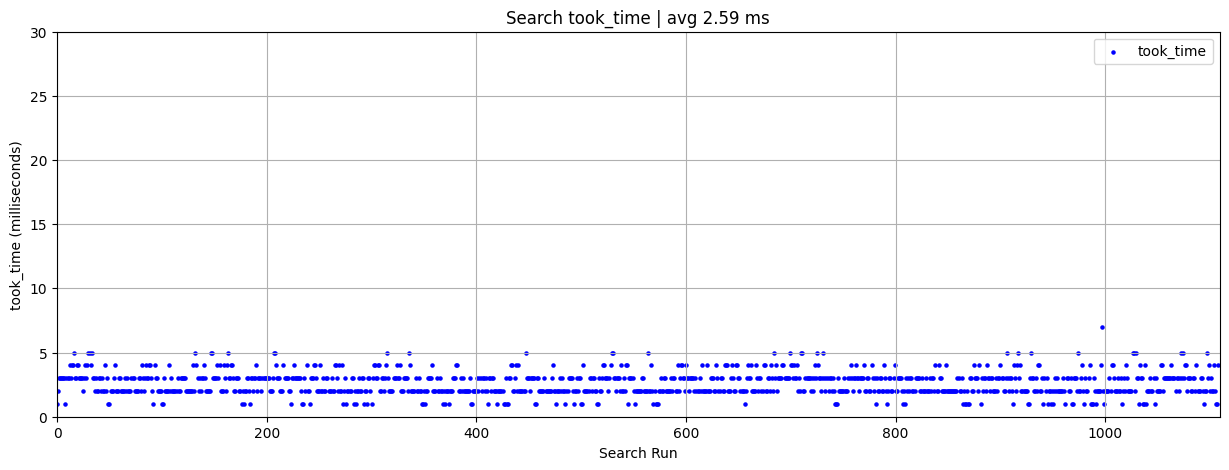

In [73]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({
    "took_time": took_time
})

avg_latency = sum(took_time) / len(took_time)

plt.figure(figsize=(15, 5))
plt.scatter(df.index, df['took_time'], label="took_time", color='blue', s=5)
plt.title(f"Search took_time | avg {avg_latency:.2f} ms")
plt.xlabel("Search Run")
plt.xlim(0, len(queries)) # change this value to view a wider range of data. (Search Run Batch)
plt.ylim(0, 30) # change this value to view the precision/recall, some values may be out of view.
plt.ylabel("took_time (milliseconds)")
plt.legend()
plt.grid(True)

plt.show()

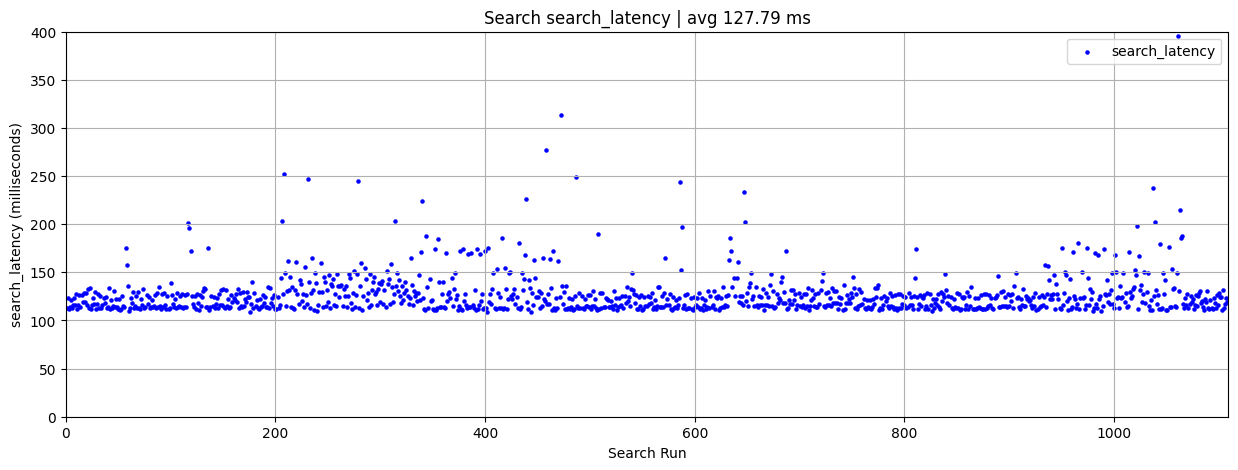

In [75]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({
    "search_latency": [(lat*1000) for lat in search_latency]
})

avg_latency = sum([(lat*1000) for lat in search_latency]) / len(search_latency)

plt.figure(figsize=(15, 5))
plt.scatter(df.index, df['search_latency'], label="search_latency", color='blue', s=5)
plt.title(f"Search search_latency | avg {avg_latency:.2f} ms")
plt.xlabel("Search Run")
plt.xlim(0, len(queries)) # change this value to view a wider range of data. (Search Run Batch)
plt.ylim(0, 400) # change this value to view the precision/recall, some values may be out of view.
plt.ylabel("search_latency (milliseconds)")
plt.legend()
plt.grid(True)

plt.show()